In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Satıcılar

🎯 Amacımız, diğerlerine göre tekrarlı olarak düşük performans gösteren satıcıları bulmak ve nedenini anlamaktır.  
Bu, Olist'in gelecekte kâr marjını artırmaya yönelik önerilerimizi şekillendirmemize yardımcı olacaktır.

## 1 - `olist/seller.py`  

`order.py` ile benzer bir süreçte, size `olist/seller.py` modülünü sunduk; içinde `Seller` sınıfı ve `Seller().get_training_data` yöntemi bulunuyor. Bu yöntem aşağıdaki özellikleri içeren bir DataFrame döndürür:

| feature_name | type | açıklama |
| --- | --- | --- |
| `seller_id` | str | satıcının benzersiz kimliği (UNIQUE) |
| `seller_city` | str | satıcının bulunduğu şehir |
| `seller_state` | str | satıcının bulunduğu eyalet |
| `delay_to_carrier` | float | sipariş, `shipping_limit_date`'den önce teslim edildiyse 0 döner; aksi takdirde gecikme süresini verir |
| `wait_time` | float | satıcı başına ortalama teslimat süresi (bekleme süresi) |
| `date_first_sale` | datetime | Olist üzerinde yapılan ilk satışın tarihi |
| `date_last_sale` | datetime | Olist üzerindeki son satışın tarihi |
| `months_on_olist` | float | Olist'te geçirilen yaklaşık ay sayısı |
| `share_of_five_stars` | float | satıcının yer aldığı siparişlerdeki beş yıldız değerlendirmelerinin oranı |
| `share_of_one_stars` | float | satıcının yer aldığı siparişlerdeki bir yıldız değerlendirmelerinin oranı |
| `review_score` | float | satıcının yer aldığı siparişler için ortalama değerlendirme puanı |
| `n_orders` | int | satıcının yer aldığı benzersiz sipariş sayısı |
| `quantity` | int | bu satıcı tarafından satılan toplam ürün adedi |
| `quantity_per_order` | float | bu satıcı için sipariş başına ortalama ürün sayısı |
| `sales` | float | bu satıcı ile ilişkili toplam satış tutarı (kargo hariç), BRL cinsinden |

❓ **Aşağıya yeni sınıfınızı import edin ve eğitim veri çerçevenizi inceleyin!** Kodları incelemek için zaman ayırın ve sizin için tam olarak nelerin hesaplandığını anlayın.

In [7]:
from olist.seller import Seller
seller = Seller()
df_train = seller.get_training_data()
df_train.info()


<class 'pandas.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


🤔 Her satıcı için henüz hesaplanması gereken bir şey kaldı:
- Aşırı yüksek değerlendirmelerin oranı (`share_of_five_stars`) ve aşırı düşük değerlendirmelerin oranı (`share_of_one_stars`)
- (ortalama) `review_score`

😱 Düşük puanlı her sipariş Olist'in itibarına olumsuz etki yapar; bu etki `cost_of_review` ile modellenir.

Bu, daha sonra her satıcı için toplam `cost_of_review`'u hesaplamamıza yardımcı olacak!

❓ **Sizin doldurmanız gereken son metod: `get_review_score()`'u implemente edin.**

In [39]:
seller = Seller()
print(seller.get_review_score())

                             seller_id  share_of_one_stars  \
0     0015a82c2db000af6aaaf3ae2ecb0532            0.333333   
1     001cca7ae9ae17fb1caed9dfb1094831            0.120000   
2     001e6ad469a905060d959994f1b41e4f            1.000000   
3     002100f778ceb8431b7a1020ff7ab48f            0.134615   
4     003554e2dce176b5555353e4f3555ac8            0.000000   
...                                ...                 ...   
3090  ffcfefa19b08742c5d315f2791395ee5            1.000000   
3091  ffdd9f82b9a447f6f8d4b91554cc7dd3            0.055556   
3092  ffeee66ac5d5a62fe688b9d26f83f534            0.142857   
3093  fffd5413c0700ac820c7069d66d98c89            0.183333   
3094  ffff564a4f9085cd26170f4732393726            0.650000   

      share_of_five_stars  review_score  
0                0.666667      3.666667  
1                0.520000      3.986309  
2                0.000000      1.000000  
3                0.519231      3.903846  
4                1.000000      5.000000  
...

🧪 Kodunuzu aşağıda test edin

In [42]:
from nbresult import ChallengeResult

tmp = Seller().get_training_data()
result = ChallengeResult('seller',
    shape = tmp.shape,
    median = tmp.review_score.median(),
    columns = tmp.columns
)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-9.0.2, pluggy-1.6.0 -- /home/demet/.pyenv/versions/3.12.9/bin/python3.12
cachedir: .pytest_cache
rootdir: /home/demet/data-sellers/tests
plugins: anyio-4.12.1
collecting ... collected 3 items

test_seller.py::TestSeller::test_column_names PASSED                     [ 33%]
test_seller.py::TestSeller::test_median_review_score PASSED              [ 66%]
test_seller.py::TestSeller::test_shape FAILED                            [100%]

=================================== FAILURES ===================================
____________________________ TestSeller.test_shape _____________________________

self = <tests.test_seller.TestSeller testMethod=test_shape>

    def test_shape(self):
>       self.assertEqual(self.result.shape, (2967, 15),
                         msg="Expected exactly 2967 rows and 15 columns")
E       AssertionError: Tuples differ: (2970, 15) != (2967, 15)


💡 **Tam satır sayısını elde edemiyor musunuz?**
<details><summary>Fazladan 3 satır mı var?</summary>
Left veya right join mi yaptınız? Nedenini anlıyoruz; fakat burada sadece değerlendirme alan satıcılarla ilgileniyoruz; bu yüzden inner join kullandık.
</details>
<details><summary>2 satır mı eksik?</summary>
`Orders().get_training_data()`'ı mı kullandınız? Bu geçerli bir seçenek, fakat sadece değerlendirmelerle ilgileniyorsak biraz aşırı olabilir. O method birçok hesaplama yapar ve döndürdüğü sütunların çoğuna ihtiyaç duymuyoruz. İhtiyacımıza daha uygun başka bir `Order` methodu bulun.
</details>

⚠️ `olist` reposundaki `seller.py` dosyasına yaptığınız kod değişikliklerini commit etmeyi unutmayın!

## 2 - Satıcıları İnceleme

### (2.1) Görselleştirmeler

Bu satıcılar hakkında ilk ***`EDA - Keşifsel Veri Analizi`*** ile başlayalım.

👉 `sellers` için özet istatistiklere bakın. Satıcı başına siparişlerin medyanı nedir ❓

In [49]:
from olist.data import Olist

olist = Olist()
data = olist.get_data()   # artık data değişkenin var

order_items = data["order_items"]

orders_per_seller = order_items.groupby("seller_id")["order_id"].nunique()

median_orders = orders_per_seller.median()
median_orders

np.float64(6.0)

👉 Bir sonraki adımda, veri setindeki her sayısal değişkenin dağılımını tek bir büyük görselde çizeceğiz. 

Kod size verildi, hücreyi çalıştırmanız yeterli.

- 👀 Herhangi bir aykırı değer fark ediyor musunuz?
- Sipariş sayısının dağılımı nasıl görünüyor ❓

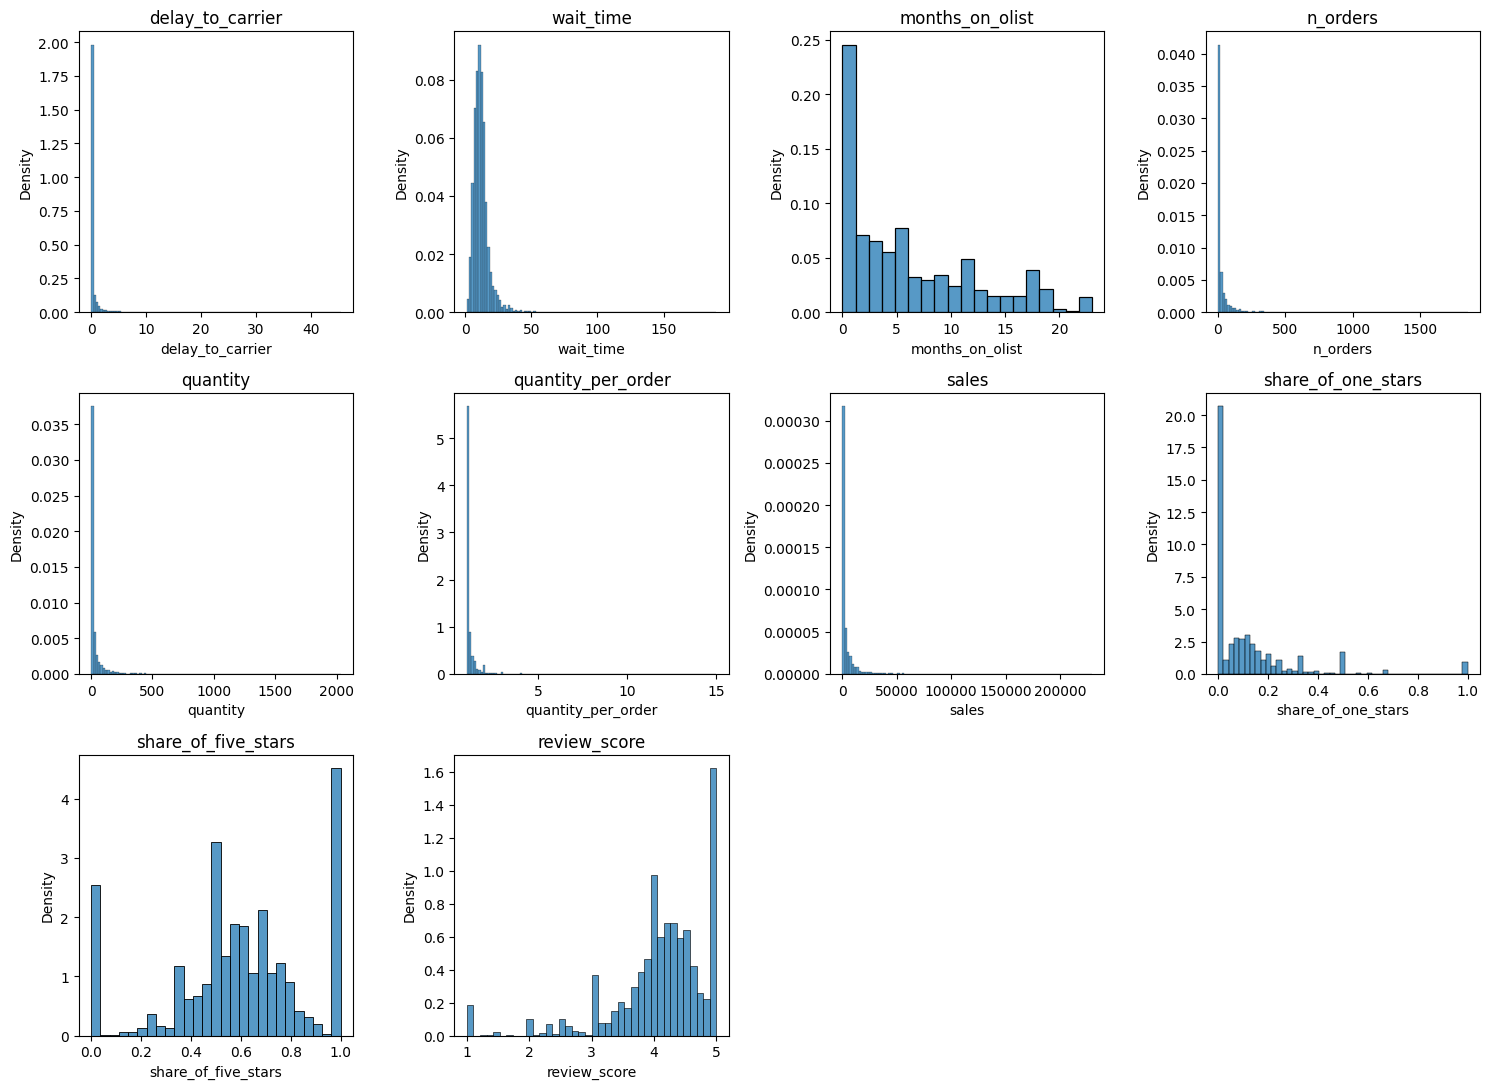

In [54]:
from olist.seller import Seller
import seaborn as sns
import matplotlib.pyplot as plt

s = Seller()
sellers = s.get_training_data()   # SADECE bunu kullan!

plt.figure(figsize=(15,11))

num_columns = sellers.select_dtypes(include='number').columns

for i, col in enumerate(num_columns):
    plt.subplot(3, 4, i+1)
    sns.histplot(sellers[col], kde=False, stat='density')
    plt.title(col)

plt.tight_layout()
plt.show()

💡 Çok düşük değerlendirme puanlarına sahip bir grup satıcının öne çıktığı görünüyor!

📊 Grafiksel olarak inceleyelim:
- `plotly` kullanarak `delay_to_carrier` ile `wait_time` arasındaki ilişkiyi gösteren bir saçılma grafiği (scatterplot) oluşturuyoruz; kabarcık boyutunu satıcının toplam `sales`'i, rengini ise `review_score` belirliyor.

`plotly`'ı daha sonra detaylı göreceğiz; şimdilik aşağıdaki hücreyi çalıştırın.

In [57]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 42.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [58]:
import plotly.express as px
fig = px.scatter(data_frame = sellers[sellers['review_score'] < 4],
    x="wait_time",
    y="delay_to_carrier",
    size="sales",
    color="review_score",
    size_max = 60,
    opacity = 0.5
)
fig.show()

En kötü satıcıları bulmak için `x`, `y`, `color` ve `size` değerlerini değiştirmekten çekinmeyin.

### (2.2) `review_score`'u OLS ile modelleme

⚠️ Saçılma grafikleri veriyi görsel olarak analiz etmemizi sağlar, fakat sınırlamaları vardır: deneme-yanılma içerir ve ilişkileri yalnızca niteliksel değerlendiririz.

💡 **Satıcıların `review_score`** değişkenini açıklamak için daha sağlam bir yöntem, `statsmodels` içinde **çok değişkenli (multivariate) OLS** kullanarak çeşitli özelliklerin `review_score` üzerindeki etkisini modellemektir.

İstediğiniz sayısal özellikleri kullanarak bir OLS oluşturalım.

👉 Regresyon katsayılarını karşılaştırabilmek için önce aşağıdaki `standardize` fonksiyonunu kullanarak özelliklerinizi standardize edin.

In [64]:
def standardize(df, features):
    """Standardize specified numerical features in a DataFrame using z-score.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    features : list of str
        List of column names to standardize.

    Returns
    -------
    pandas.DataFrame
        A copy of the original dataframe where the specified features have been
        standardized to zero mean and unit variance. Other columns are left
        unchanged.
    """
    df_standardized = df.copy()
    mu = df[features].mean()
    sigma = df[features].std()
    df_standardized[features] = (df[features] - mu) / sigma
    return df_standardized

In [60]:
sellers = s.get_training_data()

👉 Sonraki adımda bir OLS modeli oluşturun ve fit edin.

In [65]:
# 1) features listesi
features = [
    "wait_time",
    "delay_to_carrier",
    "n_orders",
    "quantity",
    "quantity_per_order",
    "sales",
    "share_of_one_stars",
    "share_of_five_stars"
]

# 2) standardize
sellers_standardized = standardize(sellers, features)

# 3) OLS model
import statsmodels.formula.api as smf

model = smf.ols(
    formula="review_score ~ " + " + ".join(features),
    data=sellers_standardized
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     6167.
Date:                Sun, 22 Feb 2026   Prob (F-statistic):               0.00
Time:                        21:43:11   Log-Likelihood:                 737.02
No. Observations:                2970   AIC:                            -1456.
Df Residuals:                    2961   BIC:                            -1402.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.1033    

❓ En etkili özellikler hangileri?

👉 Sıralanmış katsayılarla bir 📊 `bar_plot` çizin.

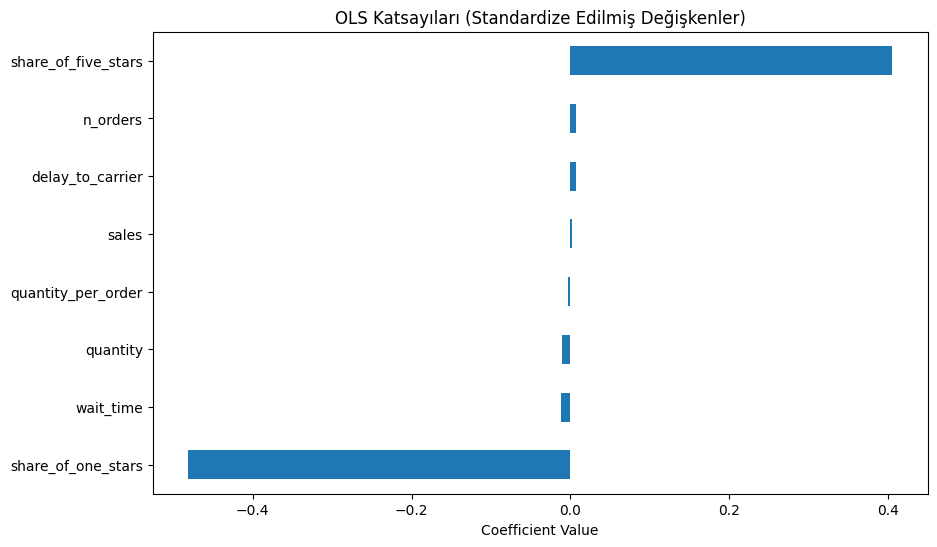

In [66]:
coef_df = model.params.drop("Intercept").sort_values()

plt.figure(figsize=(10,6))
coef_df.plot(kind="barh")
plt.title("OLS Katsayıları (Standardize Edilmiş Değişkenler)")
plt.xlabel("Coefficient Value")
plt.show()

👉 Son olarak modelinizin performansını (`R-squared`) ve `residuals`'ı inceleyin

R-squared: 0.9433812424716062
Adj. R-squared: 0.9432282704823366


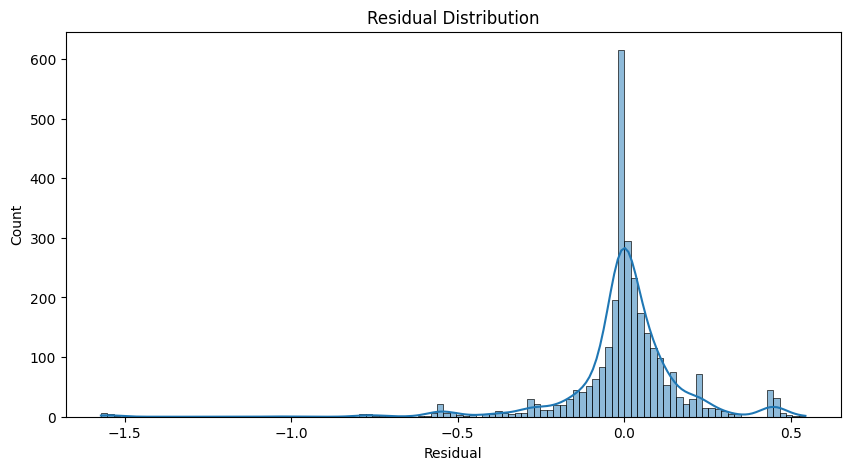

In [67]:
print("R-squared:", model.rsquared)
print("Adj. R-squared:", model.rsquared_adj)

residuals = model.resid

plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.show()

👉 Gerçek değerlendirme puanlarını ve modelin tahmin ettiği puanları aynı grafikte göstererek karşılaştırın.

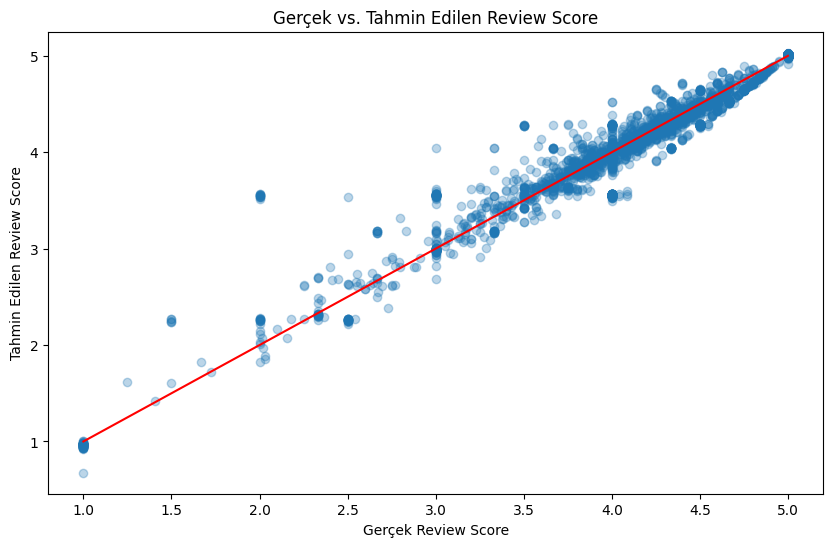

In [68]:
predictions = model.predict(sellers_standardized)

plt.figure(figsize=(10,6))
plt.scatter(sellers_standardized["review_score"], predictions, alpha=0.3)
plt.plot([1,5], [1,5], color="red")  # referans çizgisi
plt.xlabel("Gerçek Review Score")
plt.ylabel("Tahmin Edilen Review Score")
plt.title("Gerçek vs. Tahmin Edilen Review Score")
plt.show()

👉 Artıkları (residuals) görselleştirin

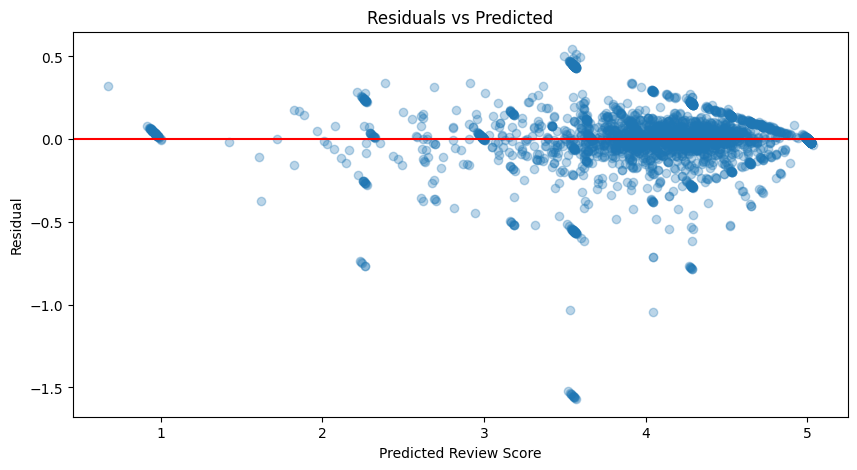

In [69]:
plt.figure(figsize=(10,5))
plt.scatter(predictions, residuals, alpha=0.3)
plt.axhline(0, color='red')
plt.xlabel("Predicted Review Score")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.show()

### (2.3) Analize `seller_state` bilgisini ekleyin

❓ Henüz `seller_state` bilgisini kullanmadık.  
- Sadece `seller_state`'lere karşı `review_score`'u regresyonla modelleyen yeni bir OLS oluşturun.
- `olist/utils.py` içinde sizin için yazılmış olan `return_significative_coef(model)` fonksiyonunu kullanarak anlamlı (significant) özellikleri analiz edin.
- `review_score` açısından en iyi eyaletler hangileri?

<details>
    <summary>- İpuçları -</summary>
        
⚠️ Dikkat, `seller_state` kategorik bir özelliktir. 
    
💡 Formülde kategorik değişkenleri belirtmek için `C(a_cat_feature)` kullanın. Bu, her benzersiz kategori için bir boolean değişken (`is_cat_feature_xx`) oluşturacaktır.

</details>

In [71]:
df_state.dtypes

review_score    float64
state_BA           bool
state_CE           bool
state_DF           bool
state_ES           bool
state_GO           bool
state_MA           bool
state_MG           bool
state_MS           bool
state_MT           bool
state_PA           bool
state_PB           bool
state_PE           bool
state_PI           bool
state_PR           bool
state_RJ           bool
state_RN           bool
state_RO           bool
state_RS           bool
state_SC           bool
state_SE           bool
state_SP           bool
dtype: object

In [72]:
import statsmodels.api as sm
import pandas as pd

# seller_state dummy kolonları
state_dummies = pd.get_dummies(
    sellers['seller_state'],
    prefix='state',
    drop_first=True,
    dtype=float              # <-- ÇÖZÜM !!
)

# model datası
df_state = pd.concat([sellers['review_score'], state_dummies], axis=1).dropna()

# review_score'u garanti float yap
df_state['review_score'] = df_state['review_score'].astype(float)

# X, y
X = df_state.drop(columns=['review_score'])
y = df_state['review_score']

# sabit terim
X = sm.add_constant(X)

# model
model_state = sm.OLS(y, X).fit()
print(model_state.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.005
Date:                Sun, 22 Feb 2026   Prob (F-statistic):              0.453
Time:                        21:49:12   Log-Likelihood:                -3516.4
No. Observations:                2970   AIC:                             7077.
Df Residuals:                    2948   BIC:                             7209.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3333      0.794      2.940      0.0

☝️ Bazı eyaletlerin ortalama olarak diğerlerinden _anlamlı_ biçimde daha iyi değerlendirmelere sahip olduğu görülebilir.

🤔 Bu, daha düşük `quantity_per_order`, daha kısa `wait_time` veya `delay_to_carrier`'dan mı kaynaklanıyor? Yoksa elimizde olmayan başka faktörlerden mi?

❓ **`seller_state` etkisini diğerlerinden izole etmeye çalışın: OLS modelinize sürekli (continuous) diğer özellikleri ekleyin; `seller_state` artık istatistiksel olarak anlamlı olmayana kadar devam edin!**

In [74]:
def return_significant_coef(model, alpha=0.05):
    """
    OLS modelinden anlamlı (p < alpha) katsayıları döndürür.
    Intercept'i dışarıda bırakır.
    """
    summary = model.summary2().tables[1]
    significant = summary[summary['P>|t|'] < alpha]
    return significant

In [75]:
from olist.utils import return_significant_coef

significant_states = return_significant_coef(model_state)
significant_states

ImportError: cannot import name 'return_significant_coef' from 'olist.utils' (/home/demet/sprint-15/olist/utils.py)

☝️ Analize `wait_time` ekledikten sonra, 22 adet `is_seller_state_xx` dummy değişkeninin hiçbirinin istatistiksel olarak anlamlı olmadığı görüldü:

Küçük veri setimiz göz önüne alındığında (çoğu eyalette çok az sayıda satıcı var):
- "Bazı eyaletlerin, `wait_time` dışındaki nedenlerle doğal olarak diğerlerinden daha iyi olduğu" sonucuna _varamayız_.
- Başka bir deyişle, "`seller_state`'in `wait_time` dışında `review_score` üzerinde etkisi yoktur" hipotezini reddedemeyiz.

🏁 Tebrikler!

💾 Commit ve push yapın:
- `sellers.ipynb` not defterinizi
- ayrıca `seller.py` dosyanızı